In [1]:
import keras
import pandas as pd
import numpy as np
import statistics as st
from keras import layers, regularizers
import sklearn.model_selection
from sklearn.linear_model import Ridge, Lasso

from sklearn.svm import SVR
import tensorflow as tf
import matplotlib.pyplot as plt
import math

In [3]:
def standardize(arr):
    return (arr - st.mean(arr)) / st.stdev(arr)

# Calculate returns, and center them
def get_standardized_returns_from_prices(arr, standardize_b=True):
    today = arr[1:]
    yesterday = arr[:-1]

    _returns = (today - yesterday) / yesterday
    if standardize_b:
        return standardize(_returns)
    else:
        return _returns
    
# Computes the sum of squared errors per each stock (by columns)
def get_communalities(measured_returns, predicted_returns):
    return np.sum((predicted_returns - measured_returns)**2, axis = 0)

# Function that takes the first price of a stock and its timestep-on-timestep interest, and returns the time series of prices
def apply_variable_comulative_interest(first_train_price, percentual_normalized_interests_time_series):
    terms = 1+np.array(percentual_normalized_interests_time_series)/100
    cumulated_interests = np.cumprod(terms)
    return first_train_price*cumulated_interests

# Equation to compute the average tracking error
def ate(R_i, R_p):  
    # len(R_i)  total number of out-of-sample trading days
    return np.sqrt((1/len(R_i))*np.sum((R_i - R_p)**2))

In [37]:
# Tied decoder layer with its own bias, taken from https://medium.com/@sahoo.puspanjali58/a-beginners-guide-to-build-stacked-autoencoder-and-tying-weights-with-it-9daee61eab2b
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
      self.dense = dense
      self.activation = keras.activations.get(activation)
      super().__init__(**kwargs)
  def build(self, batch_input_shape):
      self.biases = self.add_weight(name="bias", initializer="zeros",shape=[self.dense.input_shape[-1]])
      super().build(batch_input_shape)
  def call(self, inputs):
      z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
      return self.activation(z  + self.biases ) #

In [38]:
# Load ftsmib shares prices
ftsemib_shares_prices_df = pd.read_excel('../data/Data Index Compression.xlsx', sheet_name = 3)

# Load dividends
dividends_df = pd.read_excel('../data/Dividends.xlsx')
dividends_df.set_index("DATES", inplace=True)


# Drop lines with Nan
ftsemib_shares_prices_df = ftsemib_shares_prices_df.dropna() 

# Exclude timestamps before 9:10 and after 17:20 each day due to low liquidity
ftsemib_shares_prices_df['Dates'] = pd.to_datetime(ftsemib_shares_prices_df['Dates'])

ftsemib_shares_prices_df['Time'] = ftsemib_shares_prices_df['Dates'].dt.time

ftsemib_shares_prices_df = ftsemib_shares_prices_df[(ftsemib_shares_prices_df['Time'] >  pd.to_datetime('9:00').time()) & (ftsemib_shares_prices_df['Time'] < pd.to_datetime('17:30').time()) ]

# Compute indices correpsonding to dividends' dates
dividends_first_date_idx = len(ftsemib_shares_prices_df["Dates"][ftsemib_shares_prices_df["Dates"] <= dividends_df.index[0]])
dividends_second_date_idx = len(ftsemib_shares_prices_df["Dates"][ftsemib_shares_prices_df["Dates"] <= dividends_df.index[1]])

# Extract dates
dates = ftsemib_shares_prices_df.loc[:,"Dates"] 

# Drop dates column from data
# Interpolating the insisde area does nothing since we don't have NaN values between existing values. Anyway, we leave it for completeness. Also dropna
ftsemib_shares_prices_df = ftsemib_shares_prices_df.drop(columns = ['Dates', 'Time']).interpolate(method='linear', limit_area = "inside")

# Get total number of timestamps and of stocks
n_timestamps, n_stocks = ftsemib_shares_prices_df.shape

# convert prices to numpy array and split rain and test
ftsemib_shares_prices_npa = ftsemib_shares_prices_df.to_numpy()
stocks_prices_train_npa, stocks_prices_test_npa = sklearn.model_selection.train_test_split(ftsemib_shares_prices_npa, train_size = 0.875, shuffle = False)

train_length = stocks_prices_train_npa.shape[0]
test_length = stocks_prices_test_npa.shape[0]

# Initialize arrays of returns
returns_npa       = np.zeros(shape = ftsemib_shares_prices_npa.shape - np.array([1,0]))
returns_standardized_npa       = np.zeros(shape = ftsemib_shares_prices_npa.shape - np.array([1,0]))

# Compute returns and assign them stock-wise
for (i,col) in enumerate(ftsemib_shares_prices_npa.T):
    returns_npa[:,i] = get_standardized_returns_from_prices(col, standardize_b = False)
    
# Correct for dividends.  It is currently disabled since it slightly worsen performance
# stocks_names = list(ftsemib_shares_prices_df.columns.values) 
# for col_name in dividends_df:
#     col_idx = stocks_names.index(col_name)
#     first_dividend = dividends_df.iloc[0,col_idx]
#     second_dividend = dividends_df.iloc[1,col_idx]

#     if not math.isnan(first_dividend):
#         returns_npa[dividends_first_date_idx-1,col_idx] = returns_npa[dividends_first_date_idx-1,col_idx] + first_dividend

#     if not math.isnan(second_dividend):
#         returns_npa[dividends_second_date_idx-1,col_idx] = returns_npa[dividends_second_date_idx-1,col_idx] + second_dividend


for (i,col) in enumerate(ftsemib_shares_prices_npa.T):
    returns_standardized_npa[:,i] = standardize(returns_npa[:,i]) #get_standardized_returns_from_prices(col)


returns_train_npa = returns_npa[:(train_length-1)]
returns_test_npa = returns_npa[(train_length-1):]

returns_standardized_train_npa = np.zeros(shape = returns_train_npa.shape )
returns_standardized_test_npa  = np.zeros(shape = returns_test_npa.shape)
for (i,col) in enumerate(stocks_prices_train_npa.T):
    returns_standardized_train_npa[:,i] = standardize(returns_train_npa[:,i])

for (i,col) in enumerate(stocks_prices_test_npa.T):
    returns_standardized_test_npa[:,i] = standardize(returns_test_npa[:,i])

In [44]:
def single_hidden_layer_tied_weights_regularized(input_len, encoded_activation = "selu", decoded_activation = "linear", optimizer = "adam", loss = "mean_squared_error") :
    # input_layer = keras.Input(shape=input_shape) # layers.InputLayer(input_shape=input_shape) 
    dense_1 = layers.Dense(input_len, activation = encoded_activation, activity_regularizer = regularizers.l1(10e-5))
    latent_representation = keras.models.Sequential([
        layers.InputLayer((input_len,)) ,
        dense_1
    ])

    decoded_representation =  keras.models.Sequential([
        DenseTranspose(dense_1, activation = decoded_activation),
        layers.Reshape([input_len,1])])

    autoencoder = keras.models.Sequential([latent_representation, decoded_representation])
    autoencoder.compile(optimizer=optimizer, loss=loss)
    return  autoencoder

shl_tw_reg_ae = single_hidden_layer_tied_weights_regularized(n_stocks)

shl_tw_reg_ae.fit(returns_standardized_train_npa,returns_standardized_train_npa,
                epochs=200,
                batch_size=256,
                shuffle=False,
                validation_data=(returns_standardized_test_npa, returns_standardized_test_npa))

Epoch 1/200
10/10 [==============================] - 0s 12ms/step - loss: 0.7824 - val_loss: 0.7159
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 0.6375 - val_loss: 0.5911
Epoch 3/200
10/10 [==============================] - 0s 3ms/step - loss: 0.5342 - val_loss: 0.5020
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 0.4610 - val_loss: 0.4385
Epoch 5/200
10/10 [==============================] - 0s 3ms/step - loss: 0.4084 - val_loss: 0.3921
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 0.3692 - val_loss: 0.3565
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 0.3383 - val_loss: 0.3280
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 0.3129 - val_loss: 0.3039
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2910 - val_loss: 0.2828
Epoch 10/200
10/10 [==============================] - 0s 3ms/step - loss: 0.2714 - val_loss: 0.2637
Epoch 11

In [45]:
# It is calculated on the training set!
reconstructed_returns_npa = shl_tw_reg_ae.predict(returns_standardized_npa).squeeze()

reconstructed_returns_train_npa = shl_tw_reg_ae.predict(returns_standardized_train_npa).squeeze()
# reconstructed_returns_train_npa = reconstructed_returns_train_npa

reconstructed_returns_test_npa = shl_tw_reg_ae.predict(returns_standardized_test_npa).squeeze()

# Test mean and std of recostructed returns: they are not precisely 0 and 1. We may need to restandardize them (see later).
st.mean(reconstructed_returns_train_npa[:,3])
st.stdev(reconstructed_returns_train_npa[:,4])

# Compute communalities. Notice that we re-standardize reconstructed returns. We do it since we felt we were comparing apples and oranges if we didn't. But is it correct? Notice that results don't change very much/don't change at all in the two cases.
communalities = get_communalities(returns_standardized_train_npa, reconstructed_returns_train_npa) #np.apply_along_axis(standardize, 0, reconstructed_returns_train_npa)
communalites_descending_sortperm = np.flip(np.argsort(communalities))

# We made the proportions with Zhang2020. Initially, I took as many least communals as possible, since the minium was 1, but we already have only 2 top communals...we may come up with our own proportions later.
# Later, we increased the number if top communals and of least communals.
n_top_communal_to_keep   = 15
n_least_communal_to_keep = 5 

# Select stocks' prices and returns according to communalities
top_communals_prices_train = stocks_prices_train_npa[:,communalites_descending_sortperm[:n_top_communal_to_keep]]
top_communals_prices_test   = stocks_prices_test_npa[:,communalites_descending_sortperm[:n_top_communal_to_keep]]

top_communals_returns_train   = returns_train_npa[:,communalites_descending_sortperm[:n_top_communal_to_keep]]
top_communals_returns_test   = returns_test_npa[:,communalites_descending_sortperm[:n_top_communal_to_keep]]

top_communals_returns_standardized_train   = returns_standardized_train_npa[:,communalites_descending_sortperm[:n_top_communal_to_keep]]
top_communals_returns_standardized_test    = returns_standardized_test_npa[:,communalites_descending_sortperm[:n_top_communal_to_keep]]

least_communals_prices_train = stocks_prices_train_npa[:,communalites_descending_sortperm[-n_least_communal_to_keep:]]
least_communals_prices_test = stocks_prices_test_npa[:,communalites_descending_sortperm[-n_least_communal_to_keep:]]

least_communals_returns_train = returns_train_npa[:,communalites_descending_sortperm[-n_least_communal_to_keep:]]
least_communals_returns_test = returns_test_npa[:,communalites_descending_sortperm[-n_least_communal_to_keep:]]

least_communals_returns_standardized_train = returns_standardized_train_npa[:,communalites_descending_sortperm[-n_least_communal_to_keep:]]
least_communals_returns_standardized_test = returns_standardized_test_npa[:,communalites_descending_sortperm[-n_least_communal_to_keep:]]

selected_stocks_prices_train = np.c_[top_communals_prices_train,least_communals_prices_train]
selected_stocks_prices_test = np.c_[top_communals_prices_test,least_communals_prices_test]

selected_stocks_returns_train = np.c_[top_communals_returns_train,least_communals_returns_train]
selected_stocks_returns_test = np.c_[top_communals_returns_test,least_communals_returns_test]

selected_stocks_returns_standardized_train = np.c_[top_communals_returns_standardized_train,least_communals_returns_standardized_train]
selected_stocks_returns_standardized_test = np.c_[top_communals_returns_standardized_test,least_communals_returns_standardized_test]


selected_stocks_returns = np.append(selected_stocks_returns_train, selected_stocks_returns_test, axis=0)
selected_stocks_returns_standardized = np.append(selected_stocks_returns_standardized_train, selected_stocks_returns_standardized_test, axis=0)
selected_stocks_prices = np.append(selected_stocks_prices_train, selected_stocks_prices_test, axis=0)

12/12 [==============================] - 0s 728us/step


In [40]:
def plot_reconstructed_stocks(stock_idx, _range):
    # stock_idx = communalites_descending_sortperm[0]
    first_price = 0
    x_range = range(0)
    _returns = 0
    reconstructed_returns = 0
    if _range == "train":
        first_price = stocks_prices_train_npa[0, stock_idx]
        x_range = range(train_length - 1)
        _returns = returns_standardized_train_npa[:, stock_idx] 
        reconstructed_returns = reconstructed_returns_train_npa[:, stock_idx ]
    elif _range == "all" :
        first_price = stocks_prices_train_npa[0, stock_idx]
        x_range = range(train_length+test_length - 1)
        _returns = returns_standardized_npa[:, stock_idx] 
        reconstructed_returns = reconstructed_returns_npa[:, stock_idx ]
    elif _range == "test":
        first_price = stocks_prices_test_npa[0, stock_idx]
        x_range = range(test_length)
        _returns = returns_standardized_test_npa[:, stock_idx] 
        reconstructed_returns = reconstructed_returns_test_npa[:, stock_idx ]

    stocks_names = list(ftsemib_shares_prices_df.columns.values)
    plt.plot(x_range, apply_variable_comulative_interest(first_price,_returns ), label = "stock returns", linewidth=1.0 )
    plt.plot(x_range, apply_variable_comulative_interest(first_price,standardize(reconstructed_returns)), label = "reconstructed stock returns", linewidth=1.0 )  #dates[:returns_standardized_train_npa.shape[0]]
    if _range == "all":
        plt.axvline(train_length, color='r')
    plt.title(stocks_names[stock_idx]+"--"+_range)
    plt.xlabel("timestamp")
    plt.ylabel("price (standardized returns)")
    plt.legend()
    plt.show()

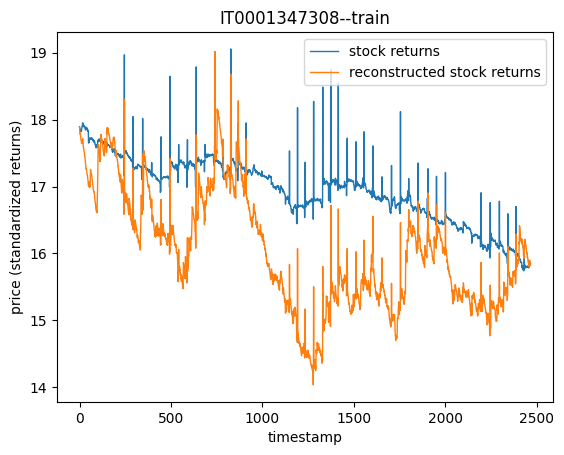

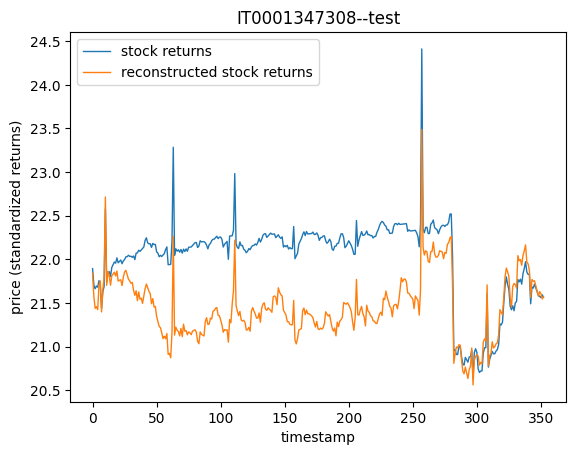

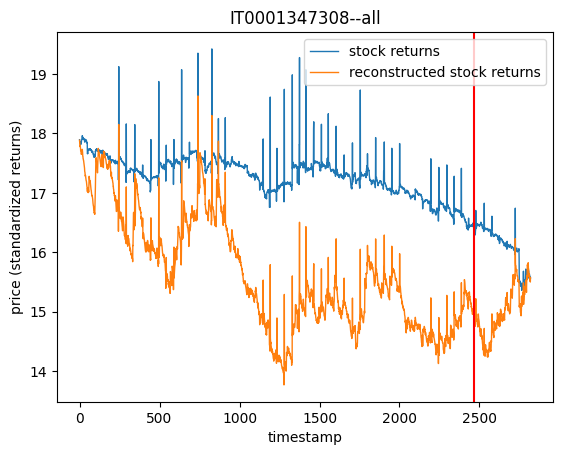

In [41]:
# Plot the stocks' real and reconstructed prices using standardized returns (see apply_variable_comulative_interest above). So these aren't the real prices. How may we recover reconstructed prices from the prediction of an autoencoder that is trained on standardized returns and as such does not predict rwal returns?
for _range in ["train", "test","all"]:
    plot_reconstructed_stocks(communalites_descending_sortperm[0], _range)

In [42]:
print(communalites_descending_sortperm)

[ 7  6 11 32  2 27 33 28 36 22  9 21 17 14 15 26 39 34 25 10 35  3  0 30
 29 16 20 12  5 37 13  4 31 23 18  8 38  1 24 19]


In [43]:
df =  pd.read_excel("../data/Data Index Compression.xlsx", sheet_name = 4)
list(ftsemib_shares_prices_df.columns.values)
np.array(df["DESCRIPTION"].to_numpy())[communalites_descending_sortperm]

array(['BZU', 'BPE', 'ENEL', 'SRG', 'AZM', 'PIRC', 'STLAM', 'PST', 'TEN',
       'IVG', 'CNHI', 'IG', 'HER', 'RACE', 'FBK', 'NEXI', 'UNI', 'STMMI',
       'MONC', 'DIA', 'TIT', 'BGN', 'A2A', 'REC', 'PRY', 'G', 'INW',
       'ENI', 'BAMI', 'TRN', 'ERG', 'BMED', 'SPM', 'LDO', 'IP', 'CPR',
       'UCG', 'AMP', 'MB', 'ISP'], dtype=object)

itm_returns_ridge_score_train: 0.0025294205084355204
itm_returns_ridge_score_test: -0.0029652742808541355
coef:
 [0.00116251 0.00196689 0.00118714 0.00070078 0.00036009 0.00207279
 0.         0.         0.         0.00015468 0.00045267 0.00056996
 0.         0.         0.00060775 0.00039651 0.         0.
 0.00014399 0.        ]
params:
 {'alpha': 1, 'copy_X': True, 'fit_intercept': False, 'max_iter': None, 'positive': True, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


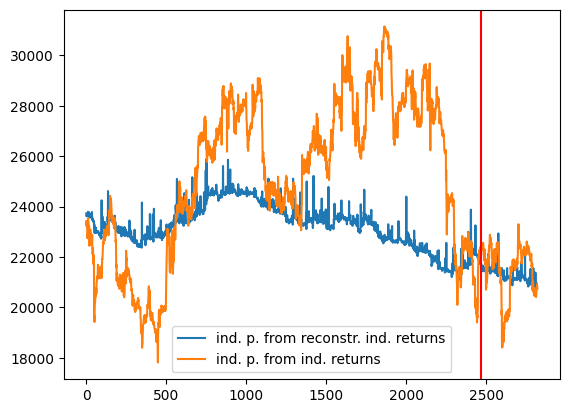

In [10]:
# Index returns time series
## Load data
ftsemib_prices_xlsx = pd.read_excel("../data/Data Index Compression.xlsx", sheet_name = 2)
# Remove dates column and  truncate the dataset so that its elements correspond to those in ftsemib_shares_prices_df timestamp-wise
ftsemib_prices_xlsx['Dates'] = pd.to_datetime(ftsemib_prices_xlsx['Dates'])

ftsemib_prices_xlsx['Time'] = ftsemib_prices_xlsx['Dates'].dt.time

ftsemib_prices_xlsx = ftsemib_prices_xlsx[(ftsemib_prices_xlsx['Time'] >  pd.to_datetime('9:00').time()) & (ftsemib_prices_xlsx['Time'] < pd.to_datetime('17:30').time()) ]

ftsemib_prices_xlsx = ftsemib_prices_xlsx.drop(columns = ['Dates'])[:n_timestamps]

# Compute (normalized) returns
ftsemib_prices_npa = ftsemib_prices_xlsx.loc[:,"STH3 Index"].to_numpy()
ftsemib_prices_train_npa = ftsemib_prices_npa[:train_length]
ftsemib_prices_test_npa = ftsemib_prices_npa[train_length:]

ftsemib_returns = get_standardized_returns_from_prices(ftsemib_prices_npa, standardize_b = False)
ftsemib_returns_train = ftsemib_returns[:(train_length-1)]
ftsemib_returns_test = ftsemib_returns[train_length-1:]

ftsemib_returns_standardized = get_standardized_returns_from_prices(ftsemib_prices_npa)
ftsemib_returns_standardized_train = ftsemib_returns_standardized[:train_length-1] 
ftsemib_returns_standardized_test =  ftsemib_returns_standardized[train_length-1:] 

# Zhang keeps stock weights non-negative beacause of "short-selling restrictions in China’s stock market." Should we do the same?
itm_returns_ridge = Ridge(alpha = 1, positive = True, fit_intercept=  False)
itm_returns_ridge.fit(selected_stocks_returns_train, ftsemib_returns_train) 

itm_returns_ridge_score_train = itm_returns_ridge.score(selected_stocks_returns_train, ftsemib_returns_train) 
print('itm_returns_ridge_score_train:',itm_returns_ridge_score_train)

itm_returns_ridge_score_test = itm_returns_ridge.score(selected_stocks_returns_test, ftsemib_returns_test)
print('itm_returns_ridge_score_test:',itm_returns_ridge_score_test)

print('coef:\n',itm_returns_ridge.coef_)

print('params:\n',itm_returns_ridge.get_params())

# Also try SVR. Does not achieve better results
svr_regr = SVR(kernel="linear")
svr_regr.fit(selected_stocks_returns_standardized_train, ftsemib_returns_standardized_train)
svr_regr.predict(selected_stocks_returns_standardized)

# Plot the index price vs the reconstructed index price using only selected stocks, from standardized returns, and weighting their prices using the coefs_ from itm_returns_ridge.
index_returns_from_selected_stocks_npa = np.array([])
for i in range(len(selected_stocks_returns)):
    weighted_sum = selected_stocks_returns[i] * itm_returns_ridge.coef_
    index_returns_from_selected_stocks_npa = np.append(index_returns_from_selected_stocks_npa, np.sum(weighted_sum) ) #


plt.plot(range(n_timestamps-1), apply_variable_comulative_interest(ftsemib_prices_npa[0], standardize(index_returns_from_selected_stocks_npa)), label='ind. p. from reconstr. ind. returns') # index_price_npa[:3618]
plt.plot(range(n_timestamps-1), apply_variable_comulative_interest(ftsemib_prices_npa[0], standardize(ftsemib_returns) ) , label='ind. p. from ind. returns')
plt.axvline(len(ftsemib_prices_train_npa), color='r')
plt.legend()
plt.show()

itm_prices_ridge_score_train: 0.9778298167278378
itm_prices_ridge_score_test: -12.03179904840863
params:
 {'alpha': 1, 'copy_X': True, 'fit_intercept': False, 'max_iter': None, 'positive': True, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


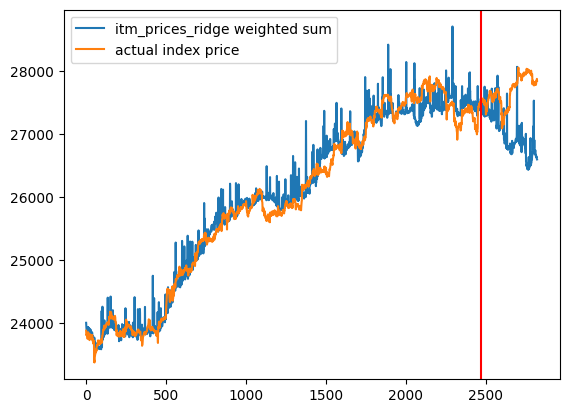

In [11]:
# We also train the same ridge index tracking model on prices, since it appears to perform way better.
# Same questions about weights. It would seem to us that it is impossible to "neagively weight" a stock.
itm_prices_ridge = Ridge(alpha = 1, positive = True, fit_intercept =  False)
itm_prices_ridge.fit(selected_stocks_prices_train, ftsemib_prices_train_npa)

itm_prices_ridge_score_train = itm_prices_ridge.score(selected_stocks_prices_train, ftsemib_prices_train_npa) # 0.90
print('itm_prices_ridge_score_train:',itm_prices_ridge_score_train)

itm_prices_ridge_score_test = itm_prices_ridge.score(selected_stocks_prices_test, ftsemib_prices_test_npa) # -89.69
print('itm_prices_ridge_score_test:',itm_prices_ridge_score_test)



print('params:\n',itm_prices_ridge.get_params())

# Plot the index price vs the reconstructed index price using only selected stocks, and weighting their prices using the coefs_ from itm_prices_ridge.
index_prices_from_selected_stocks_npa = []
for i in range(len(selected_stocks_prices)):
    weighted_sum = selected_stocks_prices[i] * itm_prices_ridge.coef_ # weights_npa itm_prices_ridge.coef_
    index_prices_from_selected_stocks_npa.append(np.sum(weighted_sum))

plt.plot(range(n_timestamps), index_prices_from_selected_stocks_npa, label='itm_prices_ridge weighted sum') 
plt.plot(range(n_timestamps), ftsemib_prices_npa, label='actual index price')
plt.axvline(len(ftsemib_prices_train_npa), color='r')
plt.legend()
plt.show()

# It is much better on the train, but much worse on the test if compared to the itm_returns_ridge.

In [12]:
itm_lasso = Lasso(alpha = 0.01, positive = True, fit_intercept=  False)
itm_lasso.fit(selected_stocks_prices_train, ftsemib_prices_train_npa)

itm_lasso_score_train = itm_lasso.score(selected_stocks_prices_train, ftsemib_prices_train_npa) # 0.89
print('itm_lasso_score_train:',itm_lasso_score_train)

itm_lasso_score_test = itm_lasso.score(selected_stocks_prices_test, ftsemib_prices_test_npa) # -39.87
print('itm_lasso_score_test:',itm_lasso_score_test)

itm_lasso_score_train: 0.954048666319008
itm_lasso_score_test: -0.3599413904710922


c:\Users\claud\.conda\envs\machine_learning_for_finance_conda_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.148e+08, tolerance: 1.664e+08
  model = cd_fast.enet_coordinate_descent(


In [13]:
# ate over normalized returns
ate_returns = ate(ftsemib_returns_test, np.sum(selected_stocks_returns_test*itm_returns_ridge.coef_, axis=1) ) 
print('ate_returns:',ate_returns)

# ate over prices
ate_prices = ate(ftsemib_prices_test_npa, np.sum(selected_stocks_prices_test*itm_prices_ridge.coef_, axis=1) )
print('ate_prices:',ate_prices)

ate_returns: 0.0011826400482168396
ate_prices: 827.3017526630788


n: 20


ate_market_value_ranking_returns: 0.0011815892969155185


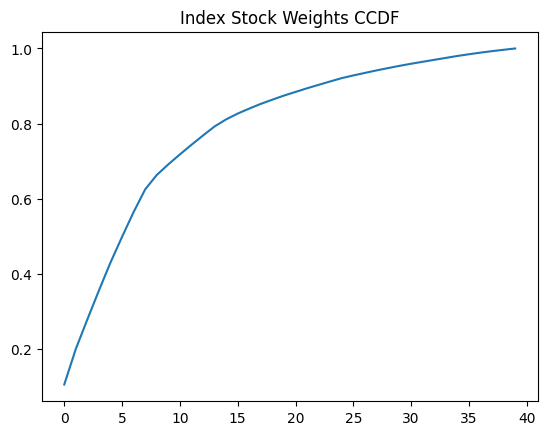

In [14]:
# Naive stock selection, selects the n stocks with the largest half-yearly average weights

ftsemib_weights_npa = pd.read_excel("../data/Data Index Compression.xlsx", sheet_name = 4).loc[:,'Shares per Basket'].to_numpy()
shares_prices_averages = np.mean(ftsemib_shares_prices_npa, axis = 0) 
ftsemib_weights_sortperm = np.flip(np.argsort(ftsemib_weights_npa * shares_prices_averages))

n = n_top_communal_to_keep + n_least_communal_to_keep
print('n:', n)

returns_train_selected_market_value = returns_train_npa[:,ftsemib_weights_sortperm[:n]]
returns_test_selected_market_value = returns_test_npa[:,ftsemib_weights_sortperm[:n]]

itm_ridge_market_value = Ridge(alpha = 0.01, positive = True, fit_intercept=  False)
itm_ridge_market_value.fit(returns_train_selected_market_value, ftsemib_returns_train)
itm_ridge_market_value.score(returns_train_selected_market_value, ftsemib_returns_train)

itm_ridge_market_value.coef_

ate_market_value_ranking_returns = ate( ftsemib_returns_test, np.sum(returns_test_selected_market_value*itm_ridge_market_value.coef_, axis=1) )
print('ate_market_value_ranking_returns:',ate_market_value_ranking_returns)

# The following plot may suggest that we actually need at least 25 top communals (or 15 top communals)
weights = ftsemib_weights_npa * shares_prices_averages
plt.plot(np.cumsum(weights[(ftsemib_weights_sortperm)]) / np.sum(weights))
plt.title('Index Stock Weights CCDF')
plt.show()

itm_market_value_ridge_score_train: 0.0014478550890147934
itm_market_value_ridge_score_test: -0.001183838079471533
coef:
 [0.         0.         0.         0.         0.00157973 0.00070078
 0.         0.00118714 0.         0.         0.         0.
 0.00060775 0.         0.00039651 0.         0.00049184 0.
 0.00217942 0.        ]
params:
 {'alpha': 1, 'copy_X': True, 'fit_intercept': False, 'max_iter': None, 'positive': True, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


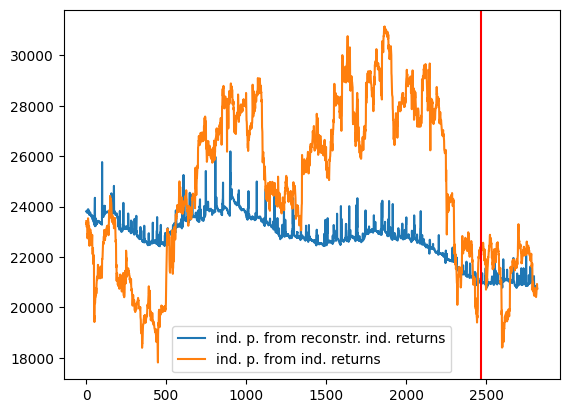

In [16]:
# Zhang keeps stock weights non-negative beacause of "short-selling restrictions in China’s stock market." Should we do the same?

stocks_returns_selected_market_value_train = returns_train_npa[:, ftsemib_weights_sortperm[:n]]
stocks_returns_selected_market_value_test = returns_test_npa[:, ftsemib_weights_sortperm[:n]]
stocks_returns_selected_market_value = returns_npa[:, ftsemib_weights_sortperm[:n]]

itm_market_value_ridge = Ridge(alpha = 1, positive = True, fit_intercept=  False)
itm_market_value_ridge.fit(stocks_returns_selected_market_value_train, ftsemib_returns_train) 

itm_market_value_ridge_score_train = itm_market_value_ridge.score(stocks_returns_selected_market_value_train, ftsemib_returns_train) 
print('itm_market_value_ridge_score_train:',itm_market_value_ridge_score_train)

itm_market_value_ridge_score_test = itm_market_value_ridge.score(stocks_returns_selected_market_value_test, ftsemib_returns_test)
print('itm_market_value_ridge_score_test:',itm_market_value_ridge_score_test)

print('coef:\n',itm_market_value_ridge.coef_)

print('params:\n',itm_market_value_ridge.get_params())

# Plot the index price vs the reconstructed index price using only selected stocks, from standardized returns, and weighting their prices using the coefs_ from itm_returns_ridge.
index_returns_from_selected_stocks_npa = np.array([])
for i in range(len(selected_stocks_returns)):
    weighted_sum = stocks_returns_selected_market_value[i] * itm_market_value_ridge.coef_
    index_returns_from_selected_stocks_npa = np.append(index_returns_from_selected_stocks_npa, np.sum(weighted_sum) ) #


plt.plot(range(n_timestamps-1), apply_variable_comulative_interest(ftsemib_prices_npa[0], standardize(index_returns_from_selected_stocks_npa)), label='ind. p. from reconstr. ind. returns') # standardize(index_returns_from_selected_stocks_npa)
plt.plot(range(n_timestamps-1), apply_variable_comulative_interest(ftsemib_prices_npa[0], standardize(ftsemib_returns) ) , label='ind. p. from ind. returns')
plt.axvline(len(ftsemib_prices_train_npa), color='r')
plt.legend()
plt.show()

itm_market_value_prices_ridge_score_train: 0.9852553368344417
itm_market_value_prices_ridge_score_test: -1.1322928185437076
coef:
 [7.83077866e+01 2.05143684e+01 1.33137862e+01 1.34528511e+02
 1.56597235e+01 1.54951918e+01 4.24274748e+01 1.31725906e+02
 3.04162594e+01 3.85439906e+01 6.11406056e+01 7.10913484e+01
 3.54023271e+02 6.60616760e+01 0.00000000e+00 1.42822531e+02
 8.19829905e+01 7.37935329e-03 1.58403796e+02 8.32524188e+01]
params:
 {'alpha': 1, 'copy_X': True, 'fit_intercept': False, 'max_iter': None, 'positive': True, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


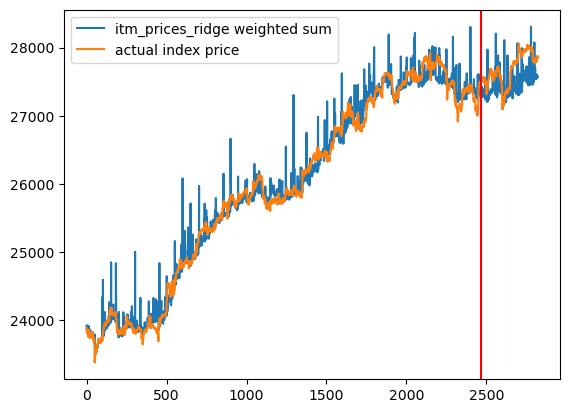

In [ ]:
# Zhang keeps stock weights non-negative beacause of "short-selling restrictions in China’s stock market." Should we do the same?

stocks_prices_selected_market_value_train = stocks_prices_train_npa[:, ftsemib_weights_sortperm[:n]]
stocks_prices_selected_market_value_test = stocks_prices_test_npa[:, ftsemib_weights_sortperm[:n]]
stocks_prices_selected_market_value = ftsemib_shares_prices_npa[:, ftsemib_weights_sortperm[:n]]

itm_market_value_prices_ridge = Ridge(alpha = 1, positive = True, fit_intercept=  False)
itm_market_value_prices_ridge.fit(stocks_prices_selected_market_value_train, ftsemib_prices_train_npa) 

itm_market_value_prices_ridge_score_train = itm_market_value_prices_ridge.score(stocks_prices_selected_market_value_train, ftsemib_prices_train_npa) 
print('itm_market_value_prices_ridge_score_train:',itm_market_value_prices_ridge_score_train)

itm_market_value_prices_ridge_score_test = itm_market_value_prices_ridge.score(stocks_prices_selected_market_value_test, ftsemib_prices_test_npa)
print('itm_market_value_prices_ridge_score_test:',itm_market_value_prices_ridge_score_test)

print('coef:\n',itm_market_value_prices_ridge.coef_)

print('params:\n',itm_market_value_prices_ridge.get_params())

# Plot the index price vs the reconstructed index price using only selected stocks, and weighting their prices using the coefs_ from itm_prices_ridge.
index_prices_from_selected_stocks_npa = []
for i in range(len(stocks_prices_selected_market_value)):
    weighted_sum = stocks_prices_selected_market_value[i] * itm_market_value_prices_ridge.coef_ # weights_npa itm_prices_ridge.coef_
    index_prices_from_selected_stocks_npa.append(np.sum(weighted_sum))

plt.plot(range(n_timestamps), index_prices_from_selected_stocks_npa, label='itm_prices_ridge weighted sum') 
plt.plot(range(n_timestamps), ftsemib_prices_npa, label='actual index price')
plt.axvline(len(ftsemib_prices_train_npa), color='r')
plt.legend()
plt.show()